In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import copy
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 定义图片的输入输出

In [28]:
def image_loader(image_name,imsize):
    """图片load函数
    """
    # 转换图片大小
    loader = transforms.Compose([
        transforms.Resize(imsize),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def image_util(img_size=512,style_img="./images/picasso.jpg", content_img="./images/dancing.jpg"):
    """返回style_image和content_image
       需要保证两张图片的大小是一样的
       """
    imsize = img_size if torch.cuda.is_available() else 128  # use small size if no gpu
    # 加载图片
    style_img = image_loader(image_name=style_img, imsize=img_size)
    content_img = image_loader(image_name=content_img, imsize=img_size)
    # 判断是否加载成功
    print("Style Image Size:{}".format(style_img.size()))
    print("Content Image Size:{}".format(content_img.size()))
    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"
    return style_img, content_img

## 定义Content Loss

In [3]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## 定义Style Loss

In [26]:
# 我们首先定义 Gram Matrix
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product
    # print(G)
    # 对Gram Matrix做正规化, 除总的大小
    return G.div(a * b * c * d)

In [21]:
x_input = torch.from_numpy(np.array([[[[1,2],[3,4]],[[5,6],[7,8]],[[9,10],[11,12]]]])).float()
x_input.size()

torch.Size([1, 3, 2, 2])

In [25]:
gram_matrix(x_input)

tensor([[ 30.,  70., 110.],
        [ 70., 174., 278.],
        [110., 278., 446.]])


tensor([[ 2.5000,  5.8333,  9.1667],
        [ 5.8333, 14.5000, 23.1667],
        [ 9.1667, 23.1667, 37.1667]])

In [27]:
# 接着我们就可以定义Style Loss了
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 基于VGG16网络的修改

In [35]:
# -------------------
# 模型的标准化
# 因为原始的VGG网络对图片做了normalization, 所在要把下面的Normalization放在新的网络的第一层
# -------------------
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [36]:
# --------------------------------
# 网络结构的修改, 生成一个style的网络
# --------------------------------
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers,
                               style_layers):
    # 复制cnn的网络部分
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    # 之后逐层向model里面增加内容
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses\
    # 只需要算到最后一个style loss或是content loss用到的layer就可以了, 后面的可以去掉
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    # 返回的是修改后的Model, style_losses和content_losses的list
    return model, style_losses, content_losses

## 定义优化算法

In [31]:
def get_input_optimizer(input_img):
    # 这里要对图片做梯度下降
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

## 定义传播函数

In [37]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, content_layers,style_layers, num_steps=300, style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers, style_layers)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img) # 前向传播
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight
            # loss为style loss 和 content loss的和
            loss = style_score + content_score
            loss.backward() # 反向传播
            # 打印loss的变化情况
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score
        # 进行参数优化
        optimizer.step(closure)
        
    # a last correction...
    # 数值范围的纠正, 使其范围在0-1之间
    input_img.data.clamp_(0, 1)

    return input_img

## 开始训练

In [38]:
# 加载content image和style image
style_img,content_img = image_util(img_size=444,style_img="./images/style/rose.jpg", content_img="./images/content/face.jpg")
# input image使用content image
input_img = content_img.clone()
# 加载预训练好的模型
cnn = models.vgg19(pretrained=True).features.to(device).eval()
# 模型标准化的值
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
# 定义要计算loss的层
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# 模型进行计算
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, content_layers=content_layers_default, style_layers=style_layers_default, num_steps=300, style_weight=100000, content_weight=1)

Style Image Size:torch.Size([1, 3, 444, 444])
Content Image Size:torch.Size([1, 3, 444, 444])
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 83.327301 Content Loss: 28.212976

run [100]:
Style Loss : 24.913506 Content Loss: 28.910002

run [150]:
Style Loss : 12.124184 Content Loss: 28.101280

run [200]:
Style Loss : 5.490695 Content Loss: 27.439909

run [250]:
Style Loss : 4.143858 Content Loss: 27.175915

run [300]:
Style Loss : 5.784199 Content Loss: 26.932138



## 图片显示

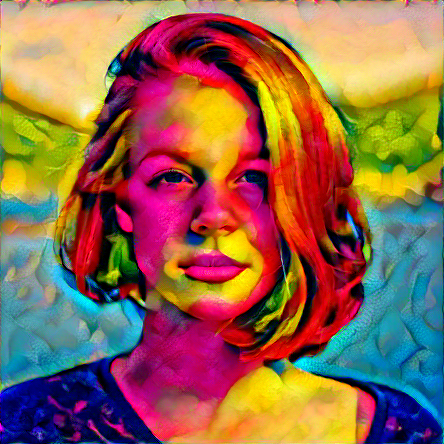

In [39]:
image = output.cpu().clone()
image = image.squeeze(0)
unloader = transforms.ToPILImage()
unloader(image)